In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
import cv2

In [2]:
nl = 1
abn = 8

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)

normal_data = x_train[y_train == nl]
normal_labels = y_train[y_train == nl]
test_data = x_test[(y_test == abn) | (y_test == nl)]
test_labels = y_test[(y_test == abn) | (y_test == nl)]
test_labels_T_F = np.where(test_labels == nl, True, False)

(60000, 28, 28, 1)


In [3]:
normal_data.shape, test_data.shape, test_labels.shape

((6742, 28, 28, 1), (2109, 28, 28, 1), (2109,))

In [4]:
normal_labels[0:20], test_labels[0:20]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint8),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 8, 1, 1, 1, 1, 8, 8, 8],
       dtype=uint8))

In [5]:
normal_test_data = test_data[test_labels == nl]
abnormal_test_data = test_data[test_labels == abn]

In [6]:
normal_test_data.shape, abnormal_test_data.shape

((1135, 28, 28, 1), (974, 28, 28, 1))

In [7]:
normal_test_labels = test_labels[test_labels == nl]
abnormal_test_labels = test_labels[test_labels == abn]
normal_test_labels[0:20], abnormal_test_labels[0:20]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint8),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       dtype=uint8))

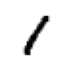

In [8]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(tf.squeeze(normal_data[0]), cmap="binary")
plt.axis('off')
plt.show()

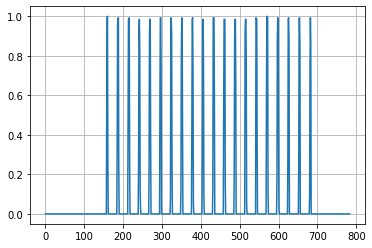

In [9]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

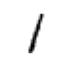

In [10]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(tf.squeeze(test_data[0]), cmap="binary")
plt.axis('off')
plt.show()

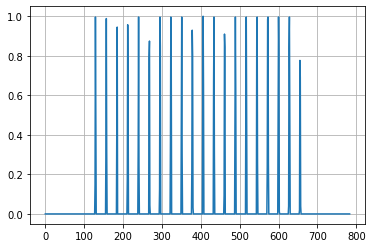

In [11]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [12]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
14/14 [==============================] - 6s 145ms/step - loss: 0.2339 - val_loss: 0.2204
Epoch 2/20
14/14 [==============================] - 1s 49ms/step - loss: 0.2097 - val_loss: 0.1849
Epoch 3/20
14/14 [==============================] - 1s 48ms/step - loss: 0.1487 - val_loss: 0.1270
Epoch 4/20
14/14 [==============================] - 1s 52ms/step - loss: 0.0827 - val_loss: 0.1004
Epoch 5/20
14/14 [==============================] - 1s 45ms/step - loss: 0.0676 - val_loss: 0.0971
Epoch 6/20
14/14 [==============================] - 1s 50ms/step - loss: 0.0659 - val_loss: 0.0962
Epoch 7/20
14/14 [==============================] - 1s 42ms/step - loss: 0.0634 - val_loss: 0.0797
Epoch 8/20
14/14 [==============================] - 1s 43ms/step - loss: 0.0450 - val_loss: 0.0548
Epoch 9/20
14/14 [==============================] - 1s 53ms/step - loss: 0.0360 - val_loss: 0.0481
Epoch 10/20
14/14 [==============================] - 1s 48ms/step - loss: 0.0318 - val_loss: 0.0441
Epoch 11

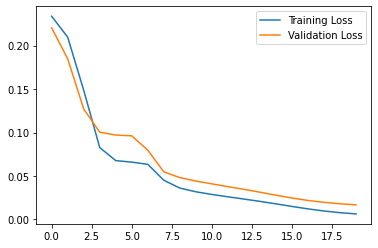

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

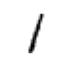

In [16]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(tf.squeeze(normal_test_data[0]), cmap="binary")
plt.axis('off')
plt.show()

In [17]:
#decoded_data = decoded_data.reshape(-1,28,28)
#decoded_data.shape

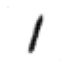

In [18]:
plt.figure(figsize=(1,1))
plt.imshow(tf.squeeze(decoded_data[0]), cmap="binary")
plt.axis('off')
plt.show()

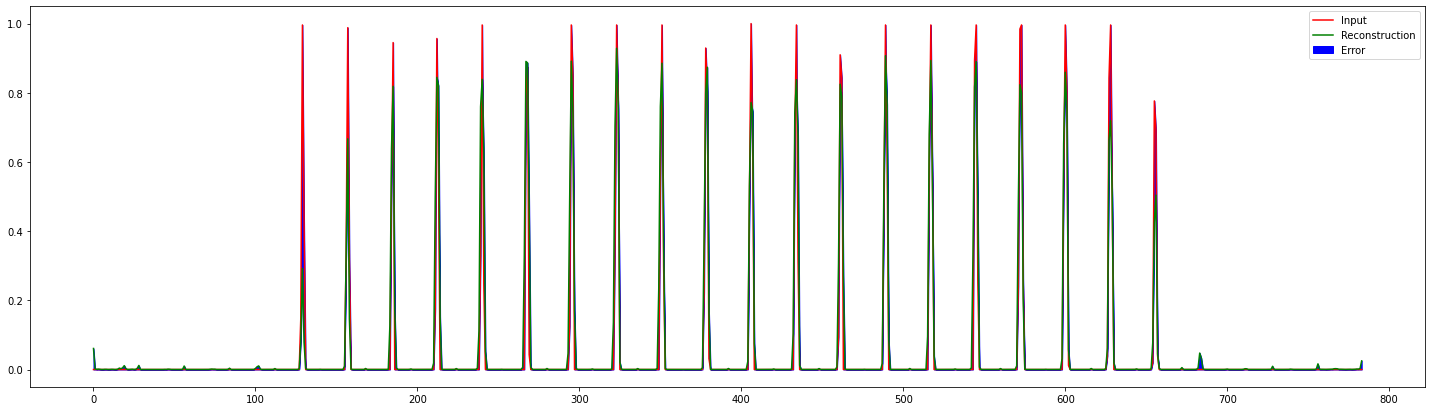

In [19]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

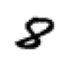

In [20]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(tf.squeeze(abnormal_test_data[0]), cmap="binary")
plt.axis('off')
plt.show()

In [21]:
#decoded_abn_data = decoded_abn_data.reshape(-1,28,28)
#decoded_abn_data.shape

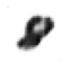

In [22]:
plt.figure(figsize=(1,1))
plt.imshow(tf.squeeze(decoded_abn_data[0]), cmap="binary")
plt.axis('off')
plt.show()

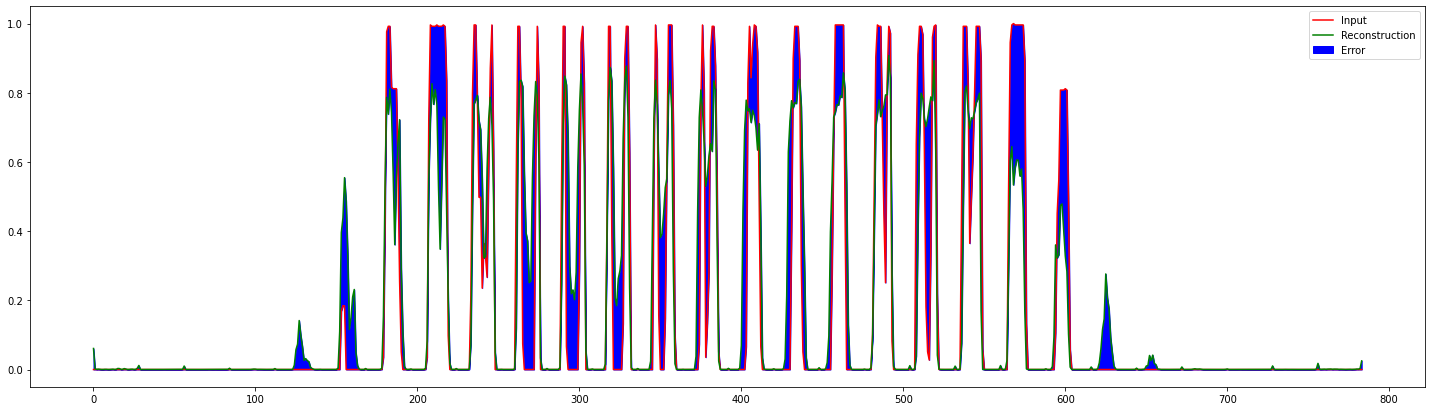

In [23]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

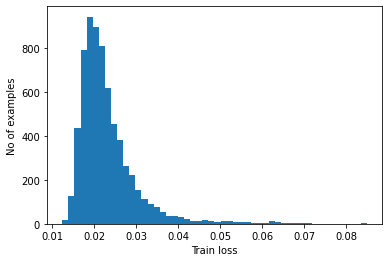

In [24]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [25]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.030262964


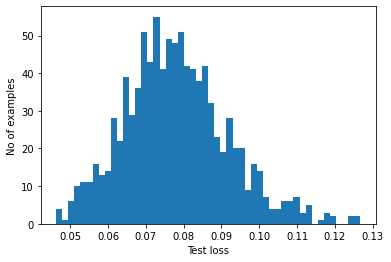

In [26]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [27]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [28]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1097   1012
 label: F   [[974   0]    974
        T    [123   1012]]   1135
Accuracy = 0.9416785206258891
Precision = 1.0
Recall = 0.8916299559471366


In [29]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 974    0]
 [ 123 1012]]


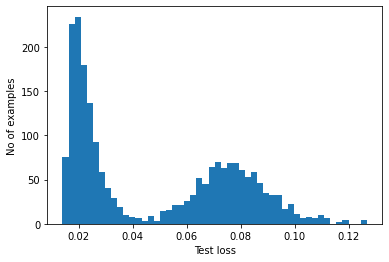

In [30]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()